# Experiment with Noise Scheduler

In [1]:
import os
from config.config import TrainingConfig
import matplotlib.pyplot as plt
import torch
from diffusers import DDIMScheduler
import dataset
from torch.utils.data import DataLoader
from utils import transforms, get_last_checkpoint
import math
import numpy as np
from numpy import random
from models.DDIM import DiffusionModel

/myhome/micromamba/envs/oadatldm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def add_noise(image, noise_scheduler, timesteps):
    noises = torch.randn(image.shape)
    noisy_images = []
    for idx, t in enumerate(timesteps):
        noisy_image = noise_scheduler.add_noise(image, noises, t)
        noisy_images.append(noisy_image)
    return noisy_images

def show_images(images, timesteps):
    num_images = len(images)
    num_rows = 2
    num_cols = math.ceil(num_images / num_rows)
    fig, axs = plt.subplots(
        num_rows, num_cols, figsize=(num_cols * 5, num_rows * 5)
    )
    axs = axs.ravel()

    for i, img in enumerate(images):
        ax = axs[i] if num_images > 1 else axs
        im = ax.imshow(img.squeeze(0).cpu(), cmap="gray", aspect="equal")
        ax.axis("off")
        ax.set_title(f"t = {timesteps[i] + 1}")
        fig.colorbar(im, ax=ax)

    for j in range(i + 1, len(axs)):
        axs[j].axis("off")
    plt.show()

In [ ]:
def cosine_beta_schedule(timesteps, s=1e-10):
    """
    Generates beta values based on a cosine noise schedule.

    Args:
        timesteps (int): Number of timesteps or betas to generate.
        s (float): A small constant to avoid extreme values near 0 and 1.

    Returns:
        numpy.ndarray: Array of betas for the cosine noise schedule.
    """
    # Step 3: Set up a linear space of timesteps
    steps = np.linspace(0, timesteps, timesteps + 1)

    # Step 4: Calculate alpha_cumprod values
    # We use cosine function to gradually reduce alphas, scaled by pi/2
    alphas_cumprod = np.cos((steps / timesteps + s) / (1 + s) * np.pi * 0.5) ** 2

    # Normalize to make sure alphas_cumprod starts at 1
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]

    # Step 5: Calculate betas based on alphas_cumprod
    # The beta at each timestep is 1 - (ratio of consecutive alphas_cumprod)
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])

    # Step 6: Clip betas to stay within [0, 0.999] range
    return np.clip(betas, 0, 0.999)


In [4]:
def sigmoid_beta_schedule(timesteps, start=0, end=1):
    steps = np.linspace(-6, 6, timesteps)
    betas = 1 / (1 + np.exp(-steps))  # Sigmoid
    # betas = start + (end - start) * betas  # Scale to [start, end]
    return betas


In [5]:
def exponential_beta_schedule(timesteps, start=1e-4, end=1e-3):
    return np.geomspace(start, end, timesteps)


In [6]:
# Number of timesteps/betas
num_betas = 1000

# Generate betas
betas = sigmoid_beta_schedule(num_betas)

# Print the first few betas to check
print(betas[:10])


[0.00247262 0.00250243 0.00253259 0.00256312 0.00259401 0.00262528
 0.00265692 0.00268894 0.00272135 0.00275414]


In [7]:
def get_named_beta_schedule(schedule_name, num_diffusion_timesteps):
    """
    Get a pre-defined beta schedule for the given name.

    The beta schedule library consists of beta schedules which remain similar
    in the limit of num_diffusion_timesteps.
    Beta schedules may be added, but should not be removed or changed once
    they are committed to maintain backwards compatibility.
    """
    if schedule_name == "linear":
        # Linear schedule from Ho et al, extended to work for any number of
        # diffusion steps.
        scale = 1000 / num_diffusion_timesteps
        beta_start = scale * 0.0001
        beta_end = scale * 0.02
        return np.linspace(
            beta_start, beta_end, num_diffusion_timesteps, dtype=np.float64
        )
    elif schedule_name == "cosine":
        return betas_for_alpha_bar(
            num_diffusion_timesteps,
            lambda t: math.cos((t + 0.008) / 1.008 * math.pi / 2) ** 2,
        )
    else:
        raise NotImplementedError(f"unknown beta schedule: {schedule_name}")


def betas_for_alpha_bar(num_diffusion_timesteps, alpha_bar, max_beta=0.999):
    """
    Create a beta schedule that discretizes the given alpha_t_bar function,
    which defines the cumulative product of (1-beta) over time from t = [0,1].

    :param num_diffusion_timesteps: the number of betas to produce.
    :param alpha_bar: a lambda that takes an argument t from 0 to 1 and
                      produces the cumulative product of (1-beta) up to that
                      part of the diffusion process.
    :param max_beta: the maximum beta to use; use values lower than 1 to
                     prevent singularities.
    """
    betas = []
    for i in range(num_diffusion_timesteps):
        t1 = i / num_diffusion_timesteps
        t2 = (i + 1) / num_diffusion_timesteps
        betas.append(min(1 - alpha_bar(t2) / alpha_bar(t1), max_beta))
    return np.array(betas)

In [15]:
betas = get_named_beta_schedule('cosine', 1000)

## Visualize noisy SWFD data

device:  cpu
random swfd idx:  22011


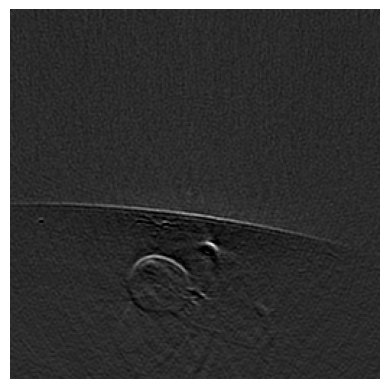

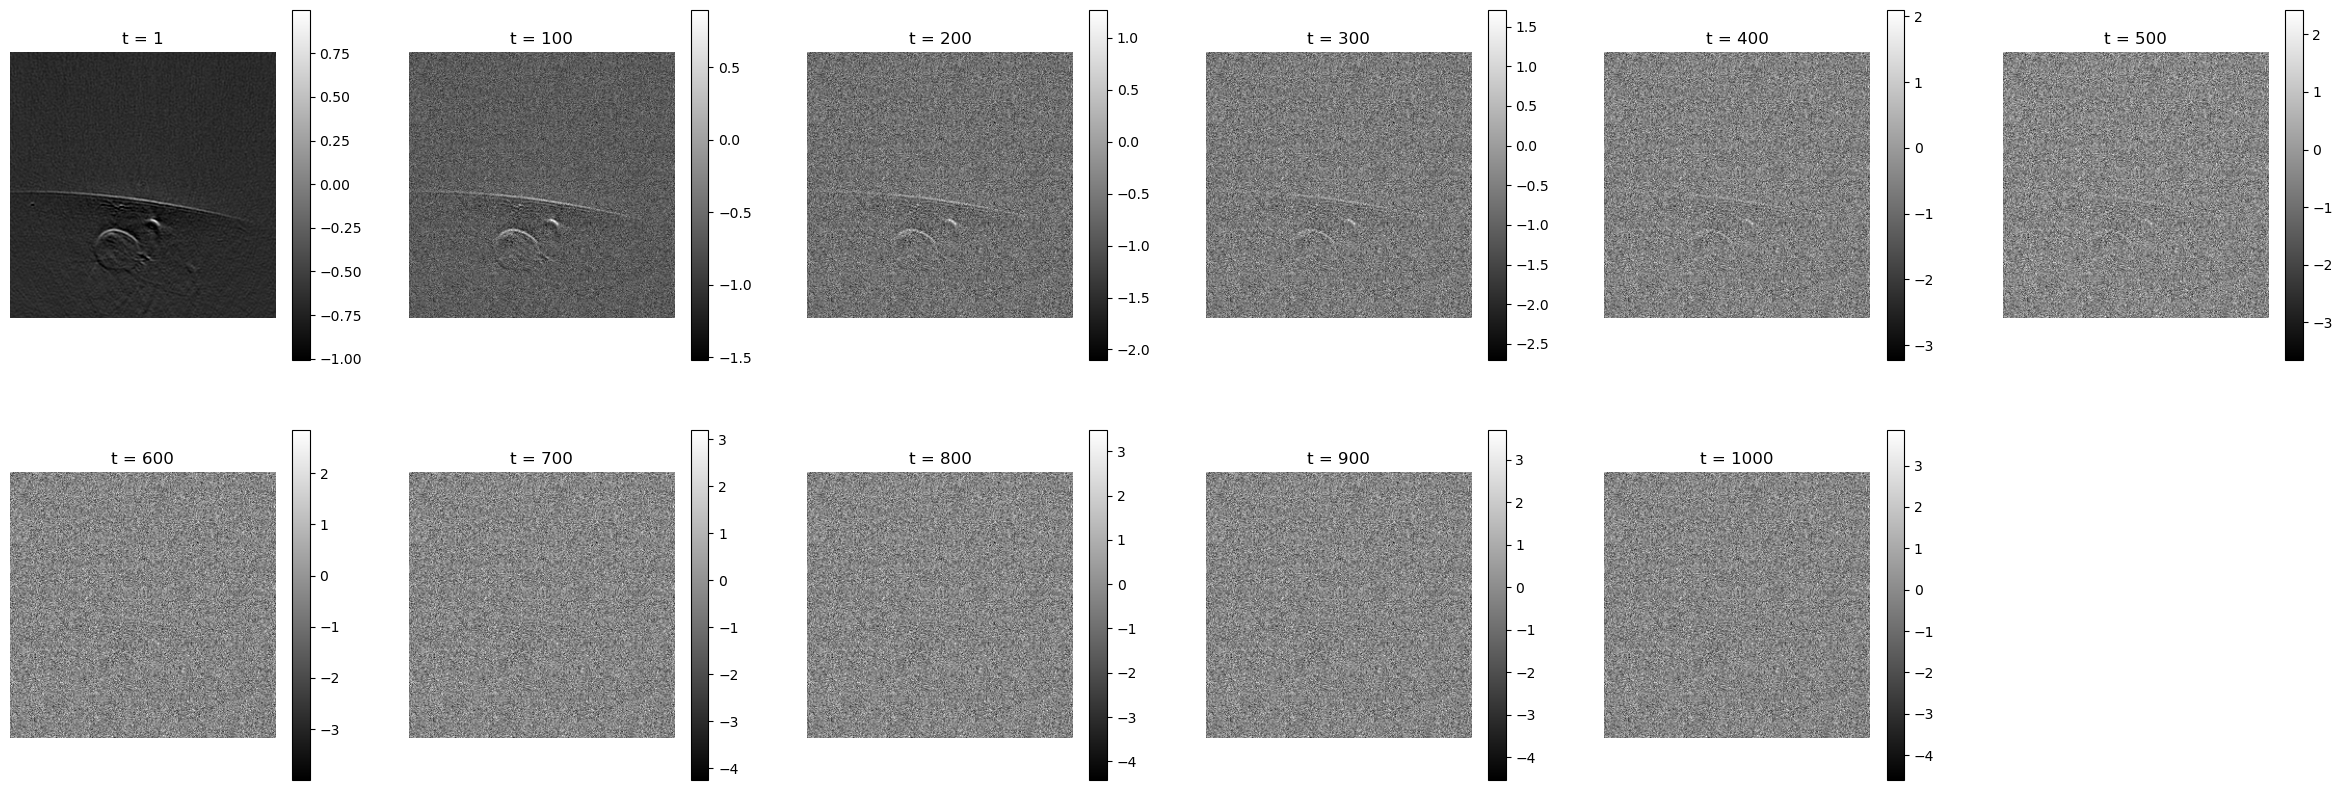

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device: ', device)
data_path = '/mydata/dlbirhoui/firat/OADAT'
swfd_fname_h5 = 'SWFD_semicircle_RawBP.h5'
swfd_key = 'sc_BP'
random_idx = random.randint(0, 30000)
print("random swfd idx: ", random_idx)
swfd_indices = [random_idx]

# Set up configuration
config = TrainingConfig(
  num_epochs=5,
  batch_size=4
)
torch.manual_seed(config.seed)

scaled_noise_scheduler = DDIMScheduler(
    num_train_timesteps=1000,
    # trained_betas=betas,
    beta_start=1e-5,
    beta_end=5e-3,
    beta_schedule='linear'
    # beta_schedule='squaredcos_cap_v2'
)

swfd_obj = dataset.Dataset(
    fname_h5=os.path.join(data_path, swfd_fname_h5),
    key=swfd_key,
    transforms=transforms,
    inds=swfd_indices,
)

swfd_image = next(iter(swfd_obj))

plt.imshow(swfd_image.transpose(1, 2, 0), cmap='gray')
plt.axis('off')  # Optional: hides axis ticks
plt.show()

# 0, 50, 100, 150, ..., 1000 (21 timesteps)
timesteps = torch.linspace(0, 999, steps=11, device=device, dtype=torch.int32)

# convert swfd_images to tensor
image_tensor = torch.tensor(swfd_image, device=device, dtype=torch.float32)
noisy_swfd_images = add_noise(image_tensor, scaled_noise_scheduler, timesteps)

# plt show
show_images(noisy_swfd_images, timesteps)


## Visualize noisy SCD data

device:  cpu
random scd idx:  17424


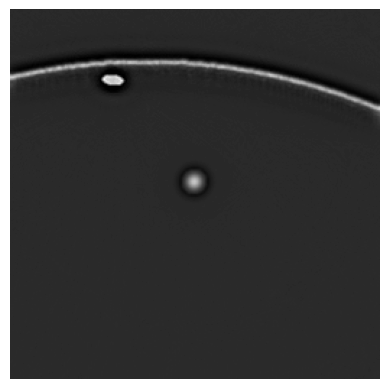

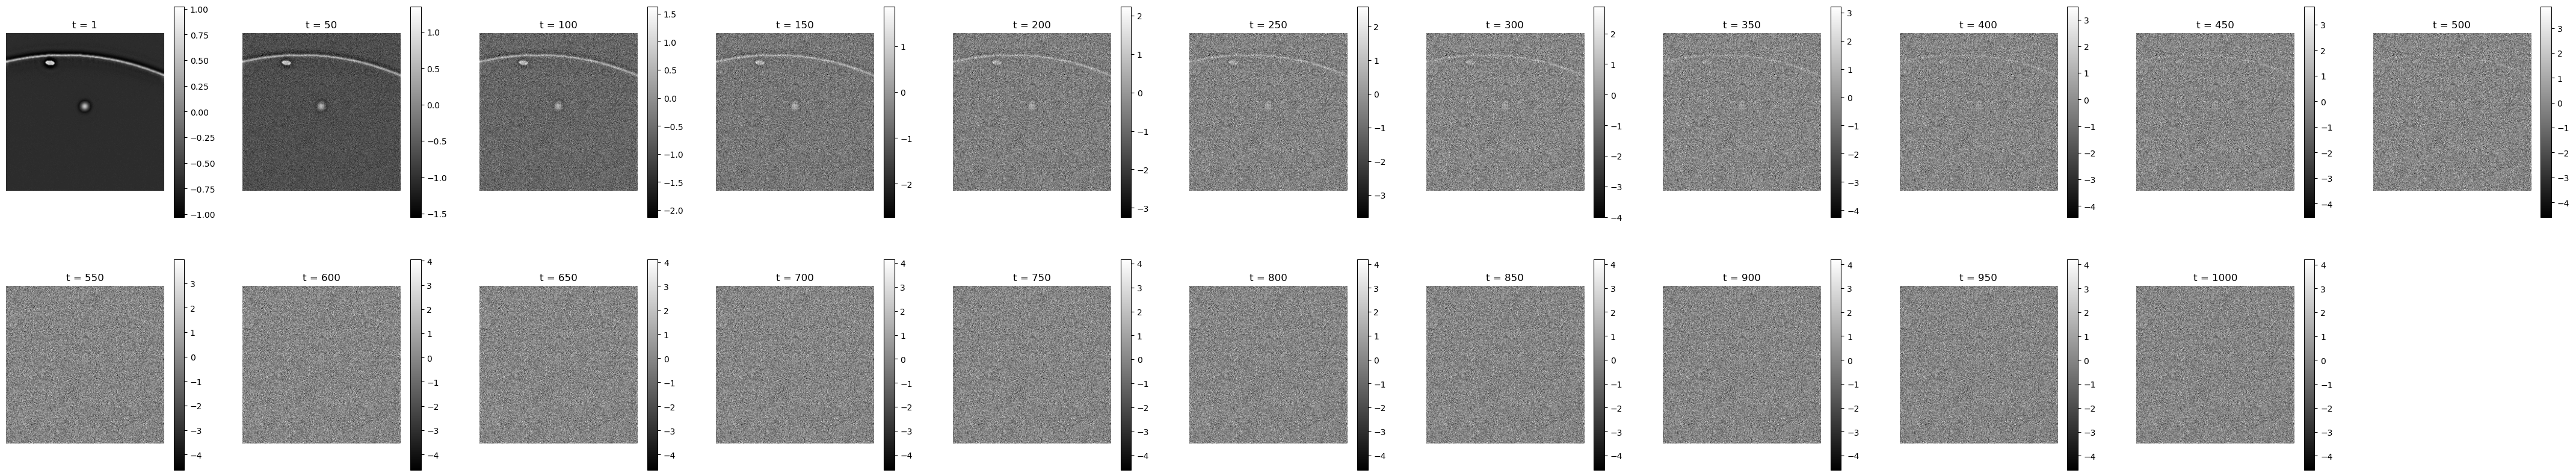

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device: ', device)
data_path = '/mydata/dlbirhoui/firat/OADAT'
scd_fname_h5 = 'SCD_RawBP.h5'
scd_key = 'vc_BP'
random_idx = 17424 # random.randint(0, 20000)
print("random scd idx: ", random_idx)
scd_indices = [random_idx]
# Set up configuration
config = TrainingConfig(
  num_epochs=5,
  batch_size=4
)
torch.manual_seed(config.seed)

scaled_noise_scheduler = DDIMScheduler(
    num_train_timesteps=1000,
    # beta_start=1e-5,
    # beta_end=8e-3,
    beta_schedule='linear'
    # beta_schedule='squaredcos_cap_v2'
    # trained_betas=betas
)

scd_obj = dataset.Dataset(
    fname_h5=os.path.join(data_path, scd_fname_h5),
    key=scd_key,
    transforms=transforms,
    inds=scd_indices,
)

scd_image = next(iter(scd_obj))

plt.imshow(scd_image.transpose(1, 2, 0), cmap='gray')
plt.axis('off')  # Optional: hides axis ticks
plt.show()

# 0, 50, 100, 150, ..., 1000 (21 timesteps)
timesteps = torch.linspace(0, 999, steps=21, device=device, dtype=torch.int32)

# convert scd_images to tensor
scd_image_tensor = torch.tensor(scd_image, device=device, dtype=torch.float32)
noisy_scd_images = add_noise(scd_image_tensor, scaled_noise_scheduler, timesteps)

# plt show
show_images(noisy_scd_images, timesteps)


## Sample images from diffusion models

image from SCD_RawBP.h5, key=vc_BP and random_idx=11619


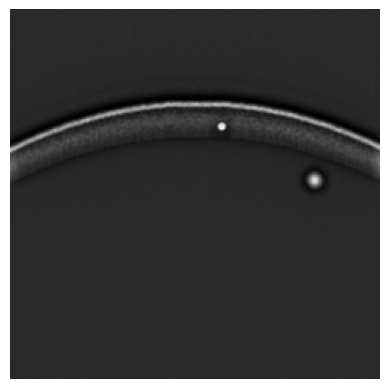

DiffusionModel(
  (model): UNet2DModel(
    (conv_in): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (time_proj): Timesteps()
    (time_embedding): TimestepEmbedding(
      (linear_1): Linear(in_features=32, out_features=128, bias=True)
      (act): SiLU()
      (linear_2): Linear(in_features=128, out_features=128, bias=True)
    )
    (down_blocks): ModuleList(
      (0-1): 2 x DownBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(32, 32, eps=1e-05, affine=True)
            (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (time_emb_proj): Linear(in_features=128, out_features=32, bias=True)
            (norm2): GroupNorm(32, 32, eps=1e-05, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
        )
        (downsamplers): 

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
ckpt_path = '/mydata/dlbirhoui/shared/chia/checkpoints/all/diffusion-model/last.ckpt'

# extract a scd image
data_path = '/mydata/dlbirhoui/firat/OADAT'
scd_fname_h5 = 'SCD_RawBP.h5'
scd_key = 'vc_BP'

# random_idx = sorted(random.randint(0, 20000, (32,)))
random_idx = 11619 # 17424 #random.randint(0, 20000)
print(f"image from {scd_fname_h5}, key={scd_key} and random_idx={random_idx}")

scd_indices = [random_idx]

scd_obj = dataset.Dataset(
    fname_h5=os.path.join(data_path, scd_fname_h5),
    key=scd_key,
    transforms=transforms,
    inds=scd_indices,
)

scd_image = next(iter(scd_obj))
plt.imshow(scd_image.transpose(1, 2, 0), cmap='gray')
plt.axis('off')
plt.show()

scd_image_tensor = torch.tensor(scd_image, device=device, dtype=torch.float32)

# define a noise scheduler
noise_scheduler = DDIMScheduler(
    num_train_timesteps=1000,
    beta_start=1e-5,
    beta_end=5e-3,
    beta_schedule='scaled_linear'
)

noise_scheduler.set_timesteps(
    num_inference_steps=1000
)

# Load the checkpoint and extract state_dict
model = DiffusionModel.load_from_checkpoint(
    checkpoint_path=ckpt_path, config=TrainingConfig(), noise_scheduler=noise_scheduler
)

model.to(device)
model.eval()

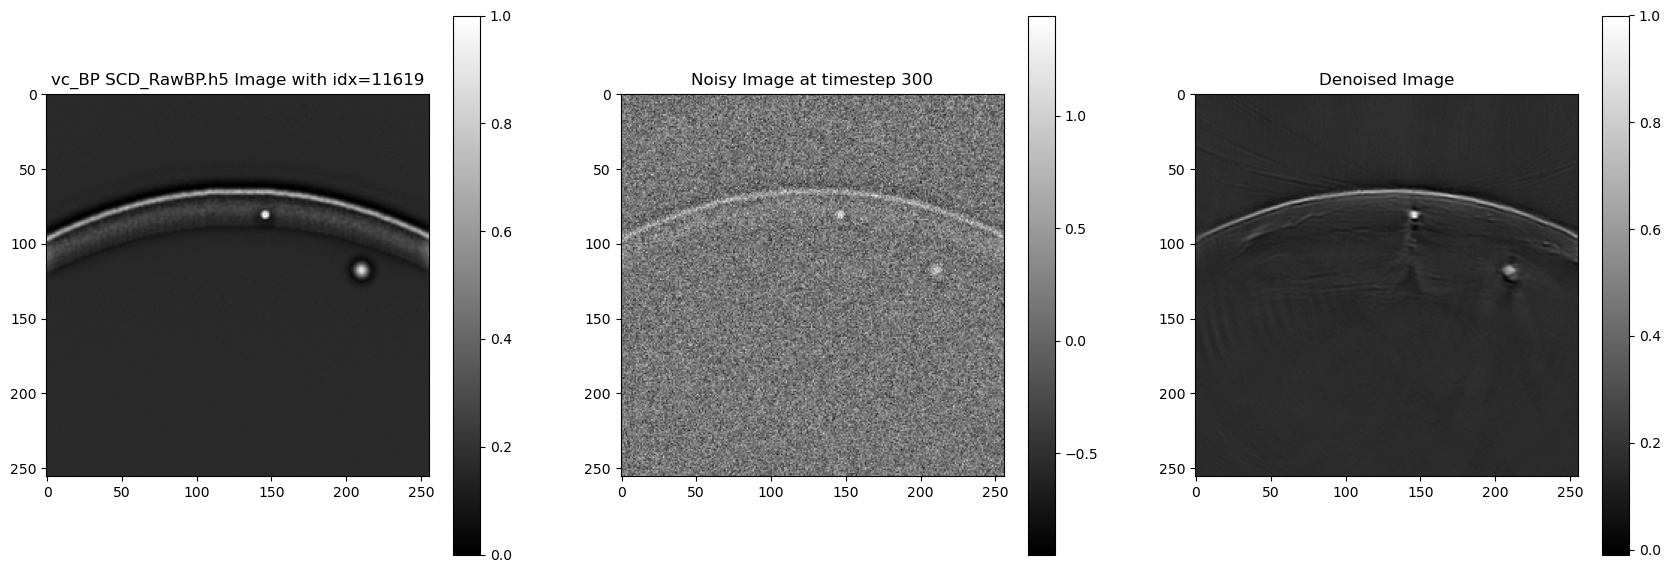

In [9]:
# define timestep
timestep = torch.tensor([300], dtype=torch.int64, device=device)

# define noise
noise = torch.randn(scd_image_tensor.unsqueeze(0).shape)

# add noise to an image
noisy_image = noise_scheduler.add_noise(scd_image_tensor.unsqueeze(0), noise, timestep)

# predict noise
noise_pred = model(noisy_image, timestep).sample

# denoise using the model
denoised_image = noise_scheduler.step(
    noise_pred[0], timestep[0], noisy_image[0]
).pred_original_sample

# show the noisy and denoised image
fig, axs = plt.subplots(1, 3, figsize=(21, 7))

# Plot the noisy image
im = axs[0].imshow(scd_image.transpose(1, 2, 0), cmap='gray')
axs[0].set_title(f"{scd_key} {scd_fname_h5} Image with idx={random_idx}")
fig.colorbar(im, ax=axs[0])

im = axs[1].imshow(noisy_image[0].squeeze(0).detach().cpu().numpy(), cmap='gray')
axs[1].set_title(f"Noisy Image at timestep {timestep[0]}")
fig.colorbar(im, ax=axs[1])

# Plot the denoised image
im = axs[2].imshow(denoised_image.squeeze(0).detach().cpu().numpy(), cmap='gray')
axs[2].set_title("Denoised Image")
fig.colorbar(im, ax=axs[2])

plt.show()

